### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In [50]:
import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras

from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
tqdm_notebook.pandas()

/home/rpo/workspace/advancedml2021/project-mercari-price/venv/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
# check if in colab
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir
    
os.chdir(base_dir)

In [4]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

True

In [5]:
if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

In [6]:
# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

In [7]:
if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

In [8]:
if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

In [9]:
if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

In [10]:
os.listdir()

['sample_submission.csv.7z',
 'MercariPrice.ipynb',
 'train.tsv',
 'requirements.txt',
 'venv',
 'test.tsv.7z',
 'mercari-price-suggestion-challenge.zip',
 'Readme.md',
 '.gitignore',
 'dataset_downloaded.ignore',
 'train.tsv.7z',
 '.ipynb_checkpoints',
 'test.tsv',
 'test_stg2.tsv.zip',
 'sample_submission_stg2.csv.zip',
 '.git']

In [11]:
dtypes={
    'name': 'string',
    'item_condition_id': 'byte',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'boolean',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', index_col="train_id", dtype=dtypes)
data

/home/rpo/workspace/advancedml2021/project-mercari-price/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,True,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,False,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,True,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,True,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,False,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,True,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,False,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,False,"Used once or twice, still in great shape."


In [12]:
data.dtypes

name                  string
item_condition_id       int8
category_name         string
brand_name            string
price                float64
shipping             boolean
item_description      string
dtype: object

In [13]:
data.shape

(1482535, 7)

In [22]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 0
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 0


In [15]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

(1482531, 7)

In [35]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

'# define the document\ntext = data["item_description"].iloc[1]\nprint(text)\n# tokenize the document\nresult = text_to_word_sequence(text)\nprint(result)'

#### split words by space, filters out punctuation and converts text to lowercase

In [40]:
data["item_description"]

train_id
0                                      No description yet
1       This keyboard is in great condition and works ...
2       Adorable top with a hint of lace and a key hol...
3       New with tags. Leather horses. Retail for [rm]...
4               Complete with certificate of authenticity
                              ...                        
9995    New. Both sets included *please only purchase ...
9996    NWT Wildfox Coachella Fringe Top size XS. Mint...
9997    Excellent condition. No tears no stains used m...
9998    A scarf is a trusty companion, covering your n...
9999    MICHAEL Michael Kors Halter Logo Tankini Top t...
Name: item_description, Length: 10000, dtype: string

In [41]:
data["item_description_tokens"] = data["item_description"].progress_apply(text_to_word_sequence)  

<ipython-input-41-75305591fd9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["item_description_tokens"] = data["item_description"].progress_apply(text_to_word_sequence)


In [42]:
data["item_description_tokens"]

train_id
0                                  [no, description, yet]
1       [this, keyboard, is, in, great, condition, and...
2       [adorable, top, with, a, hint, of, lace, and, ...
3       [new, with, tags, leather, horses, retail, for...
4         [complete, with, certificate, of, authenticity]
                              ...                        
9995    [new, both, sets, included, please, only, purc...
9996    [nwt, wildfox, coachella, fringe, top, size, x...
9997    [excellent, condition, no, tears, no, stains, ...
9998    [a, scarf, is, a, trusty, companion, covering,...
9999    [michael, michael, kors, halter, logo, tankini...
Name: item_description_tokens, Length: 10000, dtype: object

In [47]:
stop_words=nltk.corpus.stopwords.words('english')

data["item_description_tokens"] = data["item_description_tokens"].progress_apply(lambda sentence : [word for word in sentence if word not in stop_words])

<ipython-input-47-27b9e05619cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["item_description_tokens"] = data["item_description_tokens"].progress_apply(lambda sentence : [word for word in sentence if word not in stop_words])


In [48]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]


def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()


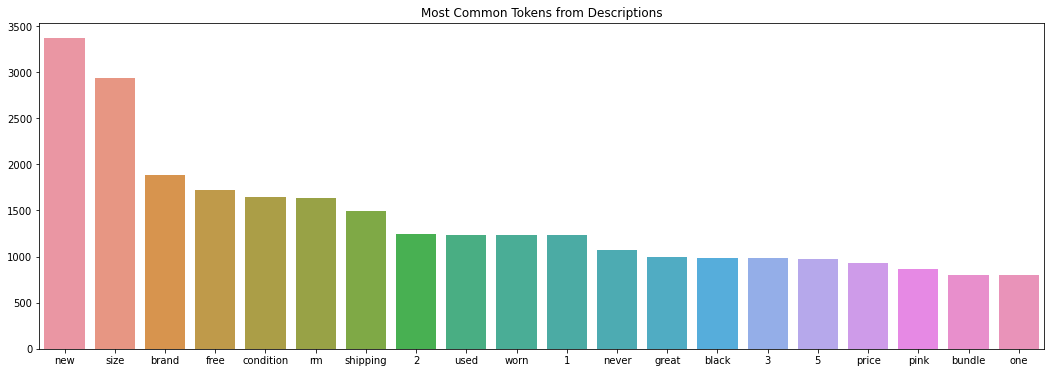

In [49]:
plot_common_tokens(data["item_description_tokens"], "Most Common Tokens from Descriptions")

In [60]:
X = data[['name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping','item_description_tokens']]
y = data['price']

In [69]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.25, random_state=1000)

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [76]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data["item_description"])

In [77]:
tokenized = tokenizer.texts_to_sequences(data["item_description"])

In [78]:
tokenized

[[12, 61, 65],
 [22,
  2880,
  10,
  5,
  35,
  18,
  1,
  182,
  47,
  20,
  756,
  57,
  11,
  2,
  54,
  32,
  11,
  2,
  2667,
  23,
  585,
  1,
  329,
  720,
  2,
  1359,
  23,
  934,
  2,
  1180,
  13,
  43,
  1572],
 [658,
  80,
  8,
  3,
  4346,
  11,
  287,
  1,
  3,
  959,
  889,
  5,
  2,
  99,
  2,
  1360,
  42,
  10,
  3,
  576,
  1,
  14,
  142,
  34,
  3,
  1880,
  155,
  5,
  66],
 [6,
  8,
  62,
  184,
  189,
  4,
  19,
  135,
  935,
  198,
  3,
  853,
  124,
  86,
  23,
  790,
  280,
  48,
  3,
  193,
  84,
  134,
  49,
  111,
  16,
  21,
  75,
  385,
  57,
  11,
  559],
 [721, 8, 11, 1573],
 [1328, 2077, 533, 528, 8, 629, 2482, 854, 3446, 533, 1, 2483, 80],
 [9, 55, 29, 439, 560, 7, 97, 248, 2668, 68, 73, 18],
 [17,
  128,
  489,
  413,
  11,
  3130,
  233,
  9,
  55,
  1,
  71,
  391,
  1,
  165,
  698,
  253,
  907,
  233,
  490,
  629,
  855,
  5,
  55,
  1,
  71,
  391,
  32,
  74,
  549,
  189,
  4,
  19,
  5,
  440,
  1,
  17,
  63,
  276,
  1881,
  618,
  4,
 

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

In [ ]:
len(tokenizer.word_index)

In [ ]:
[(key,value) for key,value in tokenizer.word_index.items() if value in range(1,10)]

In [ ]:
len(sentences_train)

In [ ]:
len(X_train)

In [ ]:
sentences_train[0]

In [ ]:
X_train[0]

In [ ]:
data[data["item_description"] == sentences_train[0]]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_validation = pad_sequences(X_validation, padding='post', maxlen=maxlen)

print(X_train[0, :])

In [ ]:
len(X_train[0])

In [ ]:
import keras.backend as K
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))


In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=256)

In [ ]:
#history1= history

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)